## Simulate a 4 x 4 network of connectivity


In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

import iv_analysis as iv
import network_sim as netsim


All neurons are recurrently connected, plus:

* x1 -> x2 -> x3
* x1 -> x4
* x2 -> x4
* x3 -> x4

In [3]:
A = np.array([
    [0.9,   0,      0,      0],
    [0.1,   0.8,    0,      0],
    [0,     0.2,    0.7,    0],
    [0.16,  0.12,   0.08,   0.54]
])

radius = max(abs(np.linalg.eig(A)[0]))
assert radius < 1, 'A is unstable'

n_chan = A.shape[0]
n_time = 10000

* Generate an IV for each region - 2.5% chance of being 1, where 1 means "hyperpolarized" and corresponding region will be 10x less active during this timepoint.

In [4]:
ivs = np.random.rand(n_chan, n_time) < 0.025

* Initialize log of network activations as Gaussian
* Also add effect of instrument to first timepoint (always reduces activation by factor of 10 if true)

In [5]:
log_act = np.zeros((n_chan, n_time))

log_act[:, 0] = np.random.randn(n_chan) + ivs[:, 0] * np.log(0.1)

* Now, run the network for `n_time` steps
* Also add effect of instrument at each step.

In [6]:
noise = np.random.normal(scale=1, size=(n_chan, n_time - 1))

for kT in range(1, n_time):
    log_act[:, kT] = A @ log_act[:, kT - 1] + noise[:, kT - 1] + ivs[:, kT] * np.log(0.1)

* Exponentiate all activations to move to a log-normal distribution (so all activations are > 0)

* Finally, plot results:
  * Timecourses of each region
  * Connectivity matrix using IV method with previous hyperpolarization of region as the "pseudo-IV"
  * Connectivity matrix using the actual instruments, which act as real IVs in this simulation
  * Plot both activations and log-activations

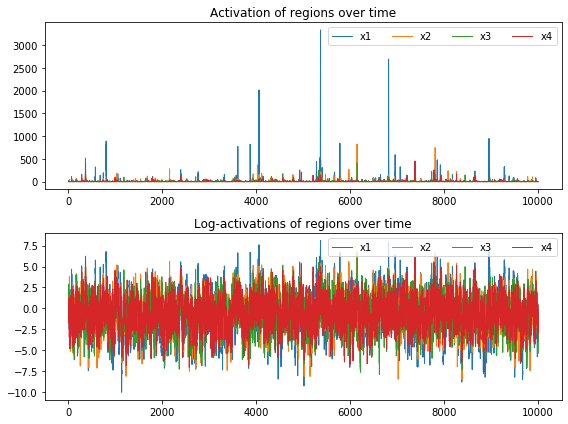

In [34]:
make_region_labels = lambda n: np.array(['x' + str(i) for i in range(1, n + 1)])

def plot_activations(lact, nfig):
    nchans, _ = lact.shape
    region_labels = make_region_labels(nchans)

    plt.close(nfig)
    fig = plt.figure(nfig, (8, 6), tight_layout=True)

    axes = fig.subplots(2, 1)
    axes[0].plot(np.exp(lact).T, linewidth=1.0)
    axes[0].legend(region_labels, ncol=6, loc='upper right')
    axes[0].set_title('Activation of regions over time')

    axes[1].plot(lact.T, linewidth=1.0)
    axes[1].legend(region_labels, ncol=6, loc='upper right')
    axes[1].set_title('Log-activations of regions over time')

    plt.draw()
    
plot_activations(log_act, 1)

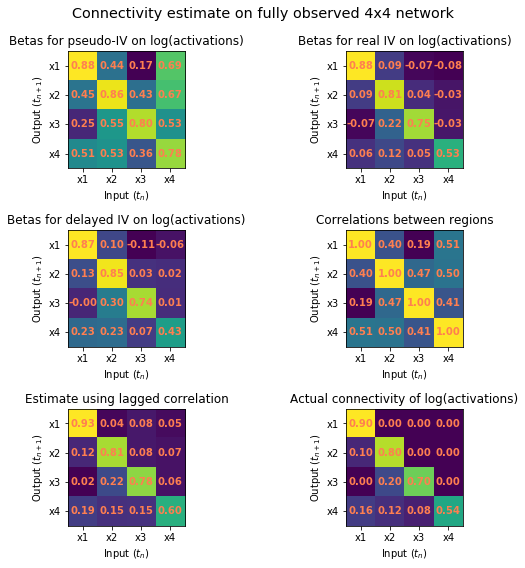

In [36]:
def plot_iv_betas(log_act_in, ivs_in, a_in, nfig, show=None, figsize=None, title=None):
    """
    :param show: If not none, should an array that can be used to index into variables
                 (e.g. a list of indices or a boolean array) to get the ones that should be plotted.
    """
    
    nchans, _ = log_act_in.shape
    if show is None:
        show = range(nchans)
        
    # for indexing into matrices
    show_ind = np.ix_(show, show)
    
    region_labels = make_region_labels(nchans)
    region_labels = region_labels[show]
    n_shown_chans = len(region_labels)
    
    plt.close(nfig)
    
    if figsize is None:
        figsize = (n_shown_chans * 2, n_shown_chans * 2)
    fig, axes = plt.subplots(3, 2, num=nfig, figsize=figsize)

    # IV analysis on log activations (should be actually linear)

    pseudo_betas_log = iv.pseudo_iv_betas(log_act_in)
    real_betas_log = iv.iv_betas(log_act_in, np.array(ivs_in, dtype=np.float64))
    delayed_betas_log = iv.delayed_iv_betas(log_act_in, np.array(ivs_in, dtype=np.float64))
    correlations_log = np.corrcoef(log_act_in)    

    axes[0, 0].imshow(pseudo_betas_log[show_ind])
    axes[0, 0].set_title('Betas for pseudo-IV on log(activations)')

    axes[0, 1].imshow(real_betas_log[show_ind])
    axes[0, 1].set_title('Betas for real IV on log(activations)')
    
    axes[1, 0].imshow(delayed_betas_log[show_ind])
    axes[1, 0].set_title('Betas for delayed IV on log(activations)')
    
    axes[1, 1].imshow(correlations_log[show_ind])
    axes[1, 1].set_title('Correlations between regions')

    a_est_lagged = iv.norm_lagged_corr(log_act_in)
    axes[2, 0].imshow(a_est_lagged[show_ind])
    axes[2, 0].set_title('Estimate using lagged correlation')
    
    # Original connectivity for comparison

    axes[2, 1].imshow(a_in[show_ind])
    axes[2, 1].set_title('Actual connectivity of log(activations)')

    for ax in axes.flatten():
        ax.set_xticks(np.arange(n_shown_chans))
        ax.set_yticks(np.arange(n_shown_chans))
        ax.set_xlim(-0.5, n_shown_chans - 0.5)
        ax.set_ylim(n_shown_chans - 0.5, -0.5)
        ax.set_xticklabels(region_labels)
        ax.set_yticklabels(region_labels)

        ax.set_xlabel(r'Input ($t_n$)')
        ax.set_ylabel(r'Output ($t_{n+1}$)')

        data = ax.get_images()[0].get_array()
        for i in range(n_shown_chans):
            for j in range(n_shown_chans):
                ax.text(j, i, '{:.2f}'.format(data[i, j]),
                        ha='center', va='center', color='coral', weight='bold')
    
    if title is not None:
        fig.suptitle(title, size='x-large')
        fig.tight_layout(rect=[0, 0, 1, 0.95])
    else:
        fig.tight_layout()
    plt.draw()
    
    return {
        'pseudo': pseudo_betas_log[show_ind],
        'real': real_betas_log[show_ind],
        'delayed': delayed_betas_log[show_ind],
        'corr': correlations_log[show_ind],
        'lagged_corr': a_est_lagged[show_ind]
    }

plot_iv_betas(log_act, ivs, A, 2, title='Connectivity estimate on fully observed 4x4 network')
plt.draw()

#### Try using correlated instead of independent noise

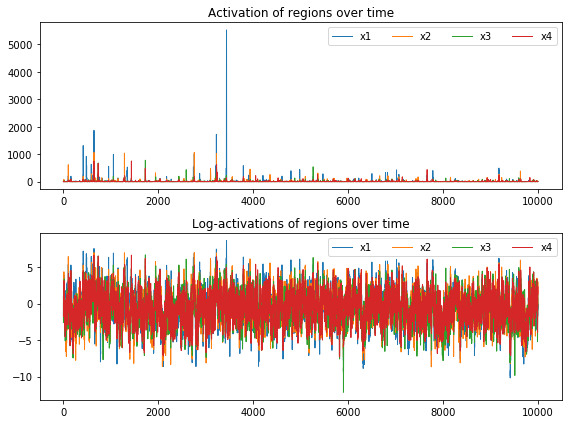

In [10]:
noise_cov = np.array([
    [1., 0.5, 0.3, 0.2],
    [0.5, 1., 0.2, 0.2],
    [0.3, 0.2, 1., 0.6],
    [0.2, 0.2, 0.6, 1.]
])

log_act2 = np.zeros((n_chan, n_time))
noise = np.random.multivariate_normal(np.zeros(4), noise_cov, n_time).T

log_act2[:, 0] = noise[:, 0] + ivs[:, 0] * np.log(0.1)

for kT in range(1, n_time):
    log_act2[:, kT] = A @ log_act2[:, kT-1] + noise[:, kT] + ivs[:, kT] * np.log(0.1)

plot_activations(log_act2, 3)

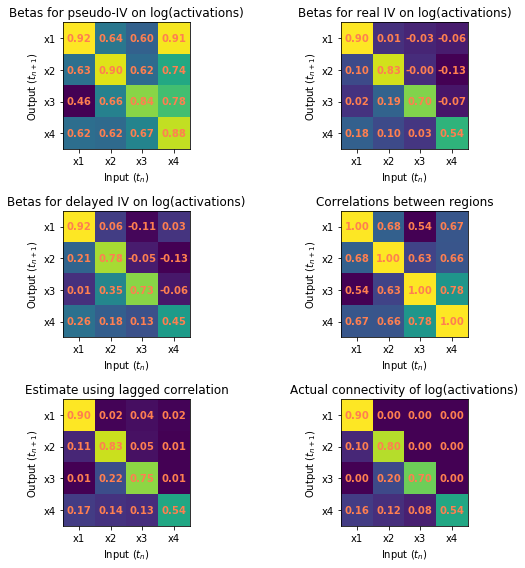

In [20]:
plot_iv_betas(log_act2, ivs, A, 4)
plt.draw()

#### Test network_sim function

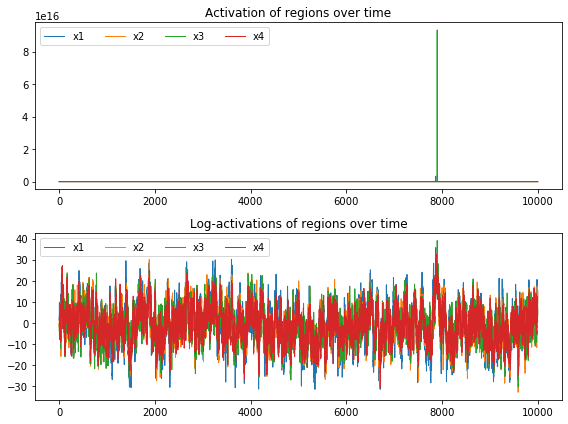

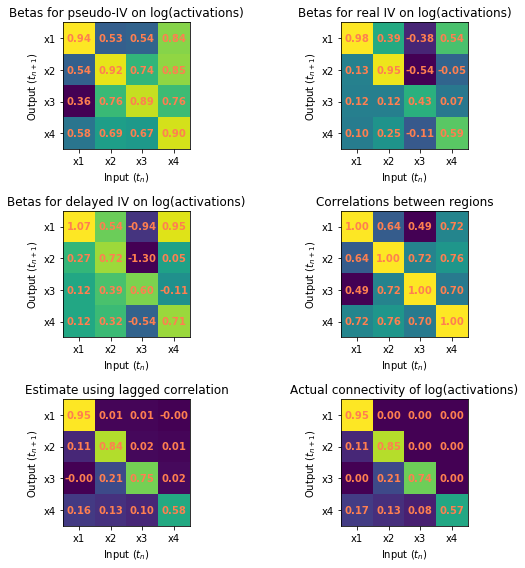

In [21]:
log_acts_from_fn, ivs_from_fn, A_scaled = netsim.sim_network(
    con_mat=A,
    n_time=n_time,
    iv_prob=0.025,
    iv_gain=0.1,
    noise_cov=10.,
    snr=10.
)

plot_activations(log_acts_from_fn, 5)
plot_iv_betas(log_acts_from_fn, ivs_from_fn, A_scaled, 6)
plt.draw()

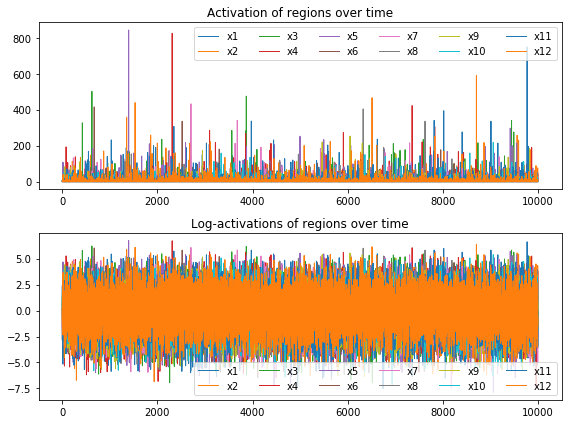

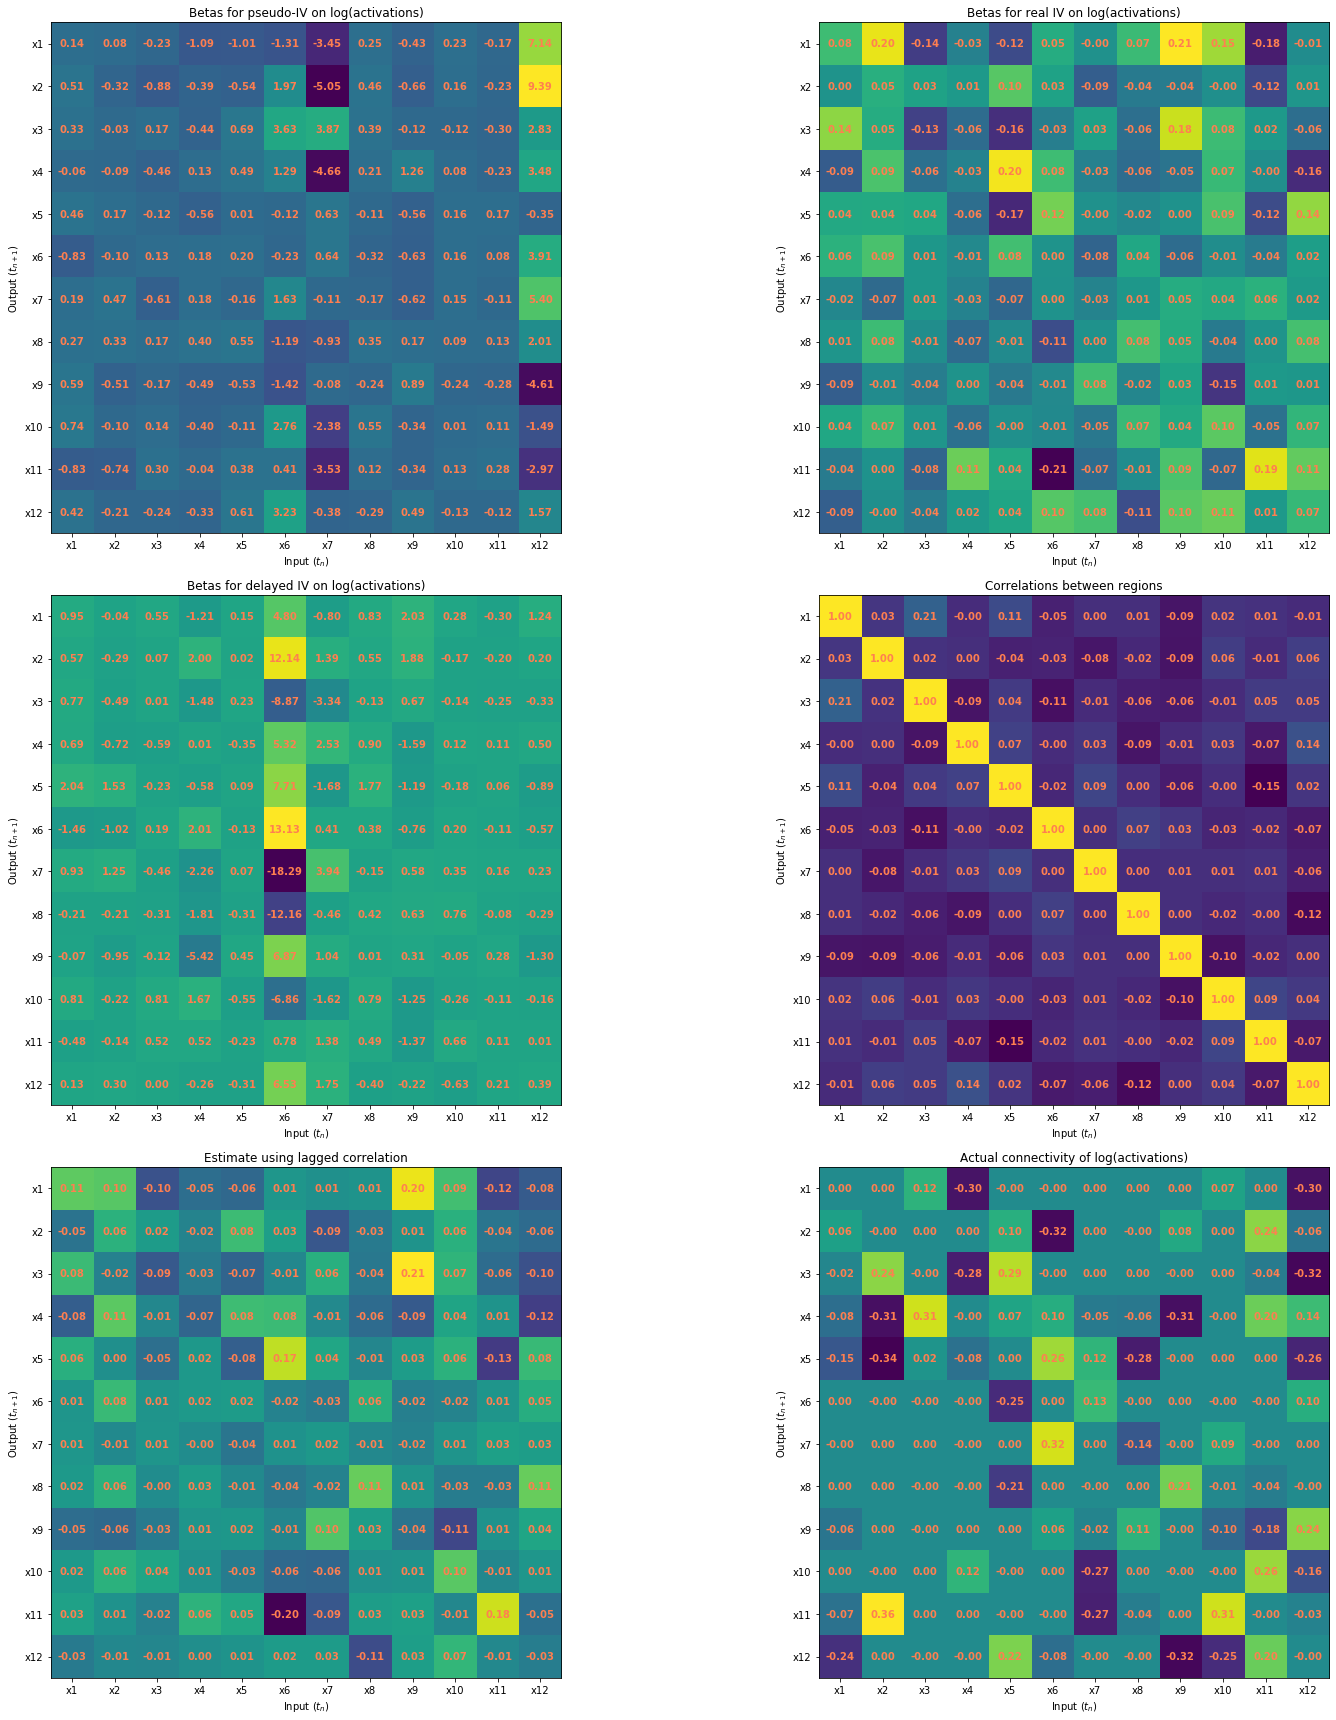

In [22]:
new_con_mat = netsim.gen_con_mat(12, max_eig=0.9, net_type='smallworld')

log_acts_from_fn2, ivs_from_fn2, new_con_mat = netsim.sim_network(
    con_mat=new_con_mat,
    n_time=n_time,
    iv_prob=0.025,
    iv_gain=0.1,
    noise_cov=2.,
    snr=0.1,
    steps_per_time=2
)

plot_activations(log_acts_from_fn2, 7)
iv_res2 = plot_iv_betas(log_acts_from_fn2, ivs_from_fn2, new_con_mat, 8)

### Make a scatterplot

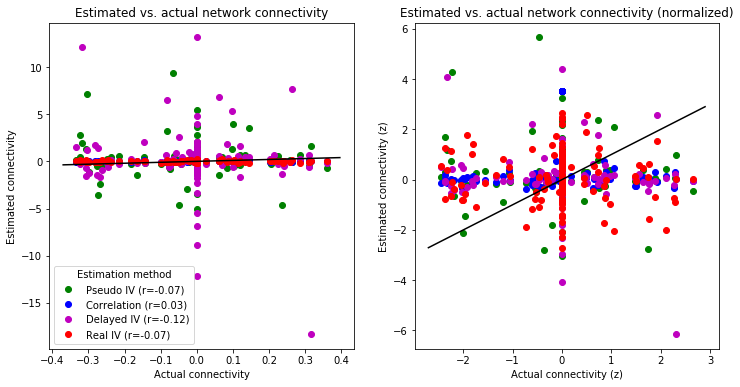

In [23]:
plt.close(9)
fig = plt.figure(9, (12, 6))
axes = [fig.add_subplot(1, 2, n) for n in (1, 2)]

# unnormalized scatterplot (showing covariance)
axes[0].plot(new_con_mat.flatten(), iv_res2['pseudo'].flatten(), 'go')
axes[0].plot(new_con_mat.flatten(), iv_res2['corr'].flatten(), 'bo')
axes[0].plot(new_con_mat.flatten(), iv_res2['delayed'].flatten(), 'mo')
axes[0].plot(new_con_mat.flatten(), iv_res2['real'].flatten(), 'ro')
axes[0].set_title('Estimated vs. actual network connectivity')

# normalize
norm_con_mat = new_con_mat / np.std(new_con_mat)
iv_res2_norm = dict()
for key, value in iv_res2.items():
    iv_res2_norm[key] = value / np.std(value)
    
# normalized scatterplot (showing correlation)
axes[1].plot(norm_con_mat.flatten(), iv_res2_norm['pseudo'].flatten(), 'go')
axes[1].plot(norm_con_mat.flatten(), iv_res2_norm['corr'].flatten(), 'bo')
axes[1].plot(norm_con_mat.flatten(), iv_res2_norm['delayed'].flatten(), 'mo')
axes[1].plot(norm_con_mat.flatten(), iv_res2_norm['real'].flatten(), 'ro')
axes[1].set_title('Estimated vs. actual network connectivity (normalized)')

real_r, _ = stats.pearsonr(new_con_mat.flatten(), iv_res2['real'].flatten())
pseudo_r, _ = stats.pearsonr(new_con_mat.flatten(), iv_res2['pseudo'].flatten())
corr_r, _ = stats.pearsonr(new_con_mat.flatten(), iv_res2['corr'].flatten())
delayed_r, _ = stats.pearsonr(new_con_mat.flatten(), iv_res2['delayed'].flatten())

# identity lines
for ax in axes:
    xlim = ax.get_xlim()
    ax.plot(xlim, xlim, 'k')

axes[0].legend([
    'Pseudo IV (r={:.2f})'.format(pseudo_r),
    'Correlation (r={:.2f})'.format(corr_r),
    'Delayed IV (r={:.2f})'.format(delayed_r),
    'Real IV (r={:.2f})'.format(real_r)
], title='Estimation method')

axes[0].set_xlabel('Actual connectivity')
axes[0].set_ylabel('Estimated connectivity')

axes[1].set_xlabel('Actual connectivity (z)')
axes[1].set_ylabel('Estimated connectivity (z)')

plt.draw()

### See what happens with partially observable network

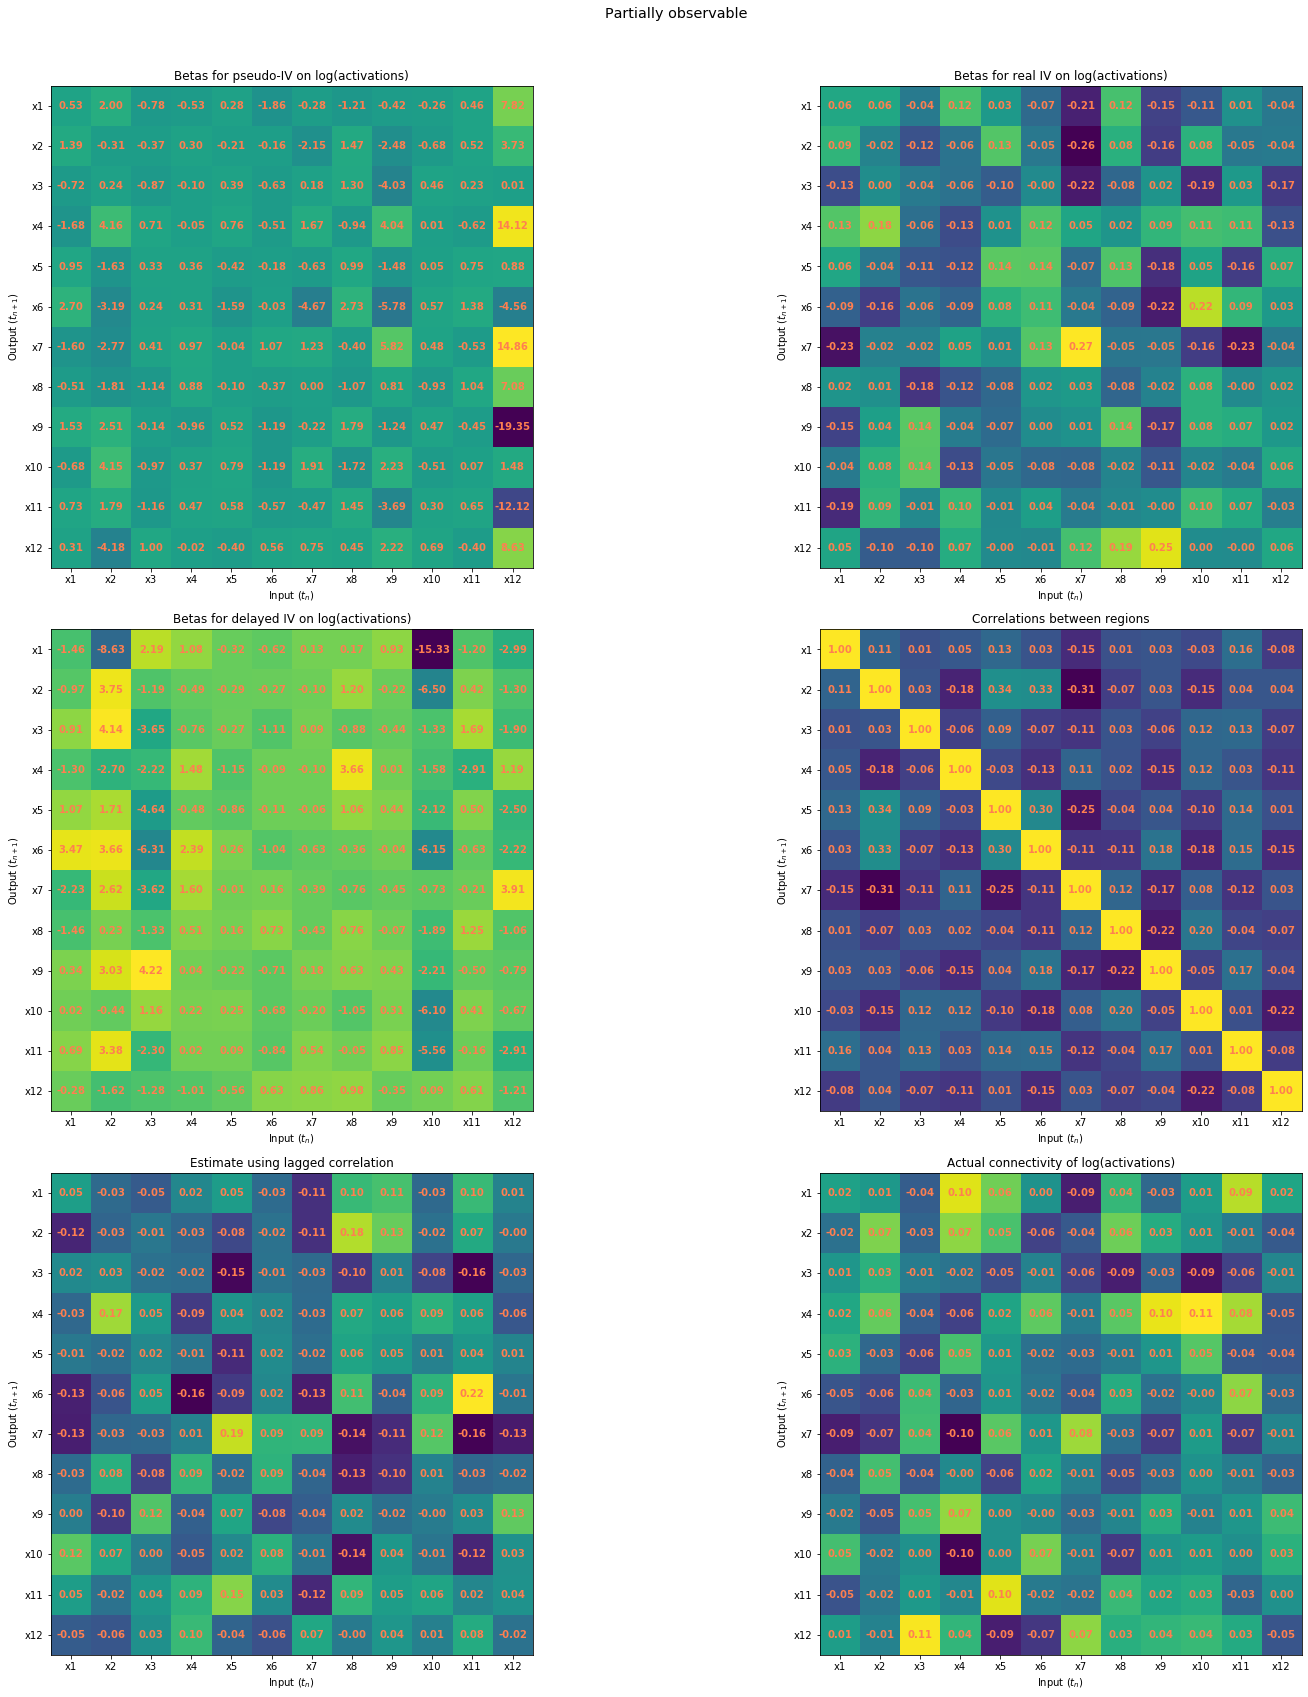

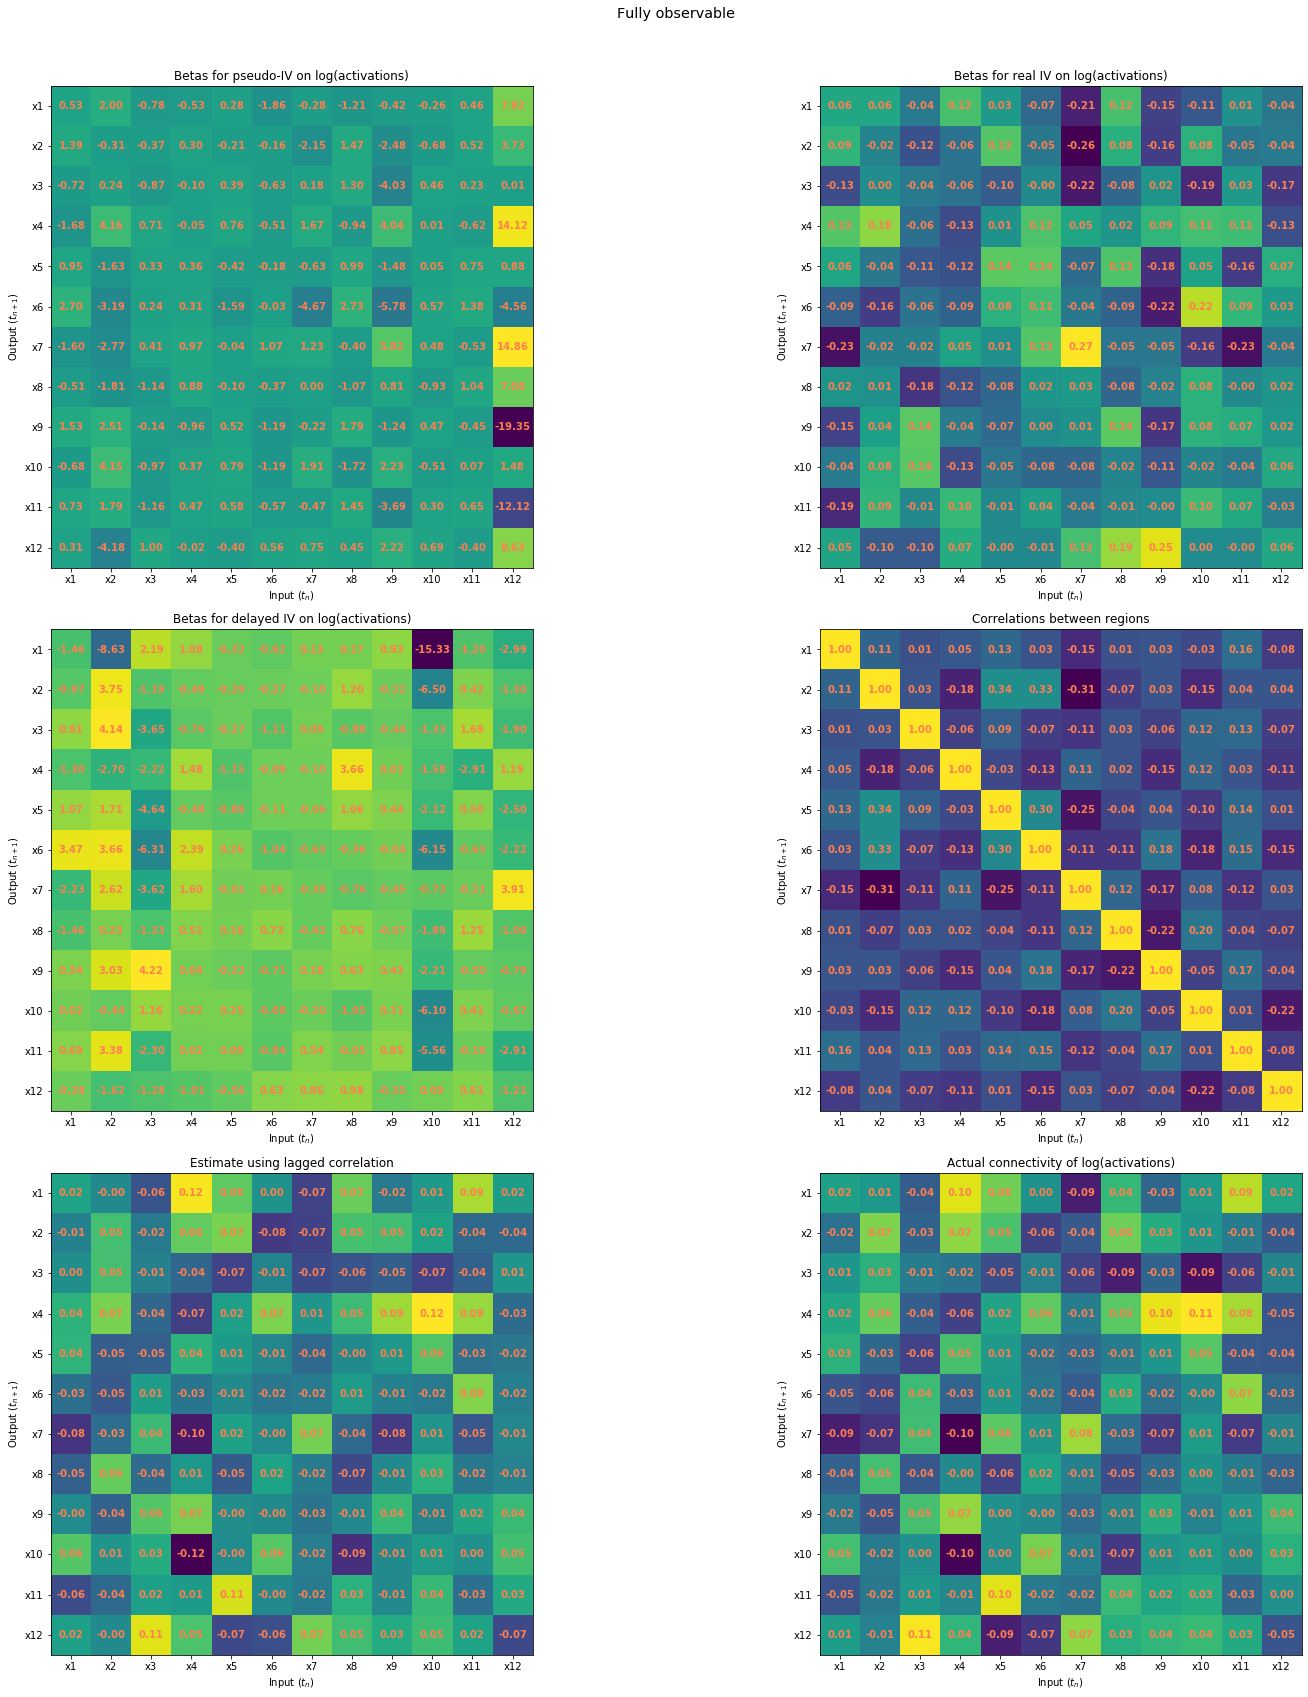

In [42]:
frac_observable = 0.1
spt = 5

n_observable = 12
n_regions = round(n_observable / frac_observable)

con_mat_all = netsim.gen_con_mat(n_regions, net_type='smallworld')

log_acts_all, ivs_all, con_mat_all = netsim.sim_network(
    con_mat=con_mat_all,
    n_time=n_time,
    iv_prob=0.025,
    iv_gain=0.1,
    noise_cov=2.,
    snr=1.,
    steps_per_time=spt
)

log_acts_obs = log_acts_all[:n_observable, :]
ivs_obs = ivs_all[:n_observable, :]
con_mat_pow = np.linalg.matrix_power(con_mat_all, spt)
con_mat_pow_obs = con_mat_pow[:n_observable, :n_observable]

#plot_activations(log_acts_all, 10)
plot_iv_betas(log_acts_obs, ivs_obs, con_mat_pow_obs, 11, title='Partially observable')
plot_iv_betas(log_acts_all, ivs_all, con_mat_pow, 12, show=range(n_observable), title='Fully observable')
plt.show()

### Expect the "estimate using lagged corrleation" to be less correlated with the true connectivity when the network is not fully obervable (top plots)